In [78]:
import pickle 
import LoadData as data
import numpy as np
from GNE import GNE
from evaluation import *
from utils import *
import pandas as pd
import scipy.sparse as sp
import random
import pandas as pd

In [2]:
# def split_seq(seq, num_splits):
#         newseq = []
#         splitsize = 1.0/num_splits*len(seq)
#         for i in range(num_splits):
#                 newseq.append(seq[int(round(i*splitsize)):int(round((i+1)*splitsize))])
#         return newseq

In [79]:
path = './data/ecoli/'

In [80]:
geneids = pd.read_csv(path + "gene_ids.tsv", sep="\t")

In [81]:
num_genes = geneids.shape[0]
link_file = path + "edgelist_biogrid.txt"

adj = load_network(link_file, num_genes)

### Loading [./data/ecoli/edgelist_biogrid.txt]...


In [82]:
np.sum(adj)

148340.0

In [9]:
def create_dataset_for_comparison(path, adj):
    print("Creating 2 split of data")
    g = nx.Graph(adj)
    adj = nx.to_scipy_sparse_matrix(g)
    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()

    # Split link information to train and validation with test split size
    edgelist = convertAdjMatrixToSortedRankTSV(adj.todense())
    geneids = edgelist.iloc[:, :2]
    col1 = np.array(geneids).min(axis=1).astype(int)
    col2 = np.array(geneids).max(axis=1).astype(int)
    col3 = np.array(edgelist.iloc[:, 2])
    data_df = pd.DataFrame()
    data_df['i'] = col1
    data_df['j'] = col2
    data_df['k'] = col3
    data_df = data_df.drop_duplicates()

    pos_edges = data_df.loc[data_df.iloc[:, 2] == 1]
    neg_edgelist = data_df.loc[data_df.iloc[:, 2] == 0]
    ind = random.sample(range(len(neg_edgelist)), pos_edges.shape[0])
    neg_edges = pd.DataFrame(np.random.permutation(neg_edgelist.values))
    neg_edges = neg_edges.iloc[ind, :]

#     assert set(map(tuple, pos_edges)).isdisjoint(set(map(tuple, neg_edges)))
    return pos_edges, neg_edges

In [7]:
X_pos, X_neg = create_dataset_for_comparison(path, adj)

Creating 2 split of data


In [31]:
X_pos, X_neg = X_pos.values, X_neg.values

In [32]:
X_pos, X_neg = X_pos.astype(int), X_neg.astype(int)

In [33]:
randomized_indices = np.random.permutation(range(len(X_pos)))

In [34]:
index_splits = split_seq(range(len(X_pos)), 2)

In [35]:
test_index = randomized_indices[index_splits[1]]

In [36]:
train_index = randomized_indices[index_splits[0]]

In [62]:
train_edges = X_pos[train_index,:]
train_edges_false = X_neg[train_index,:]
val_edges = X_pos[train_index,:]
val_edges_false = X_neg[train_index,:]
test_edges = X_pos[test_index,:]
test_edges_false = X_neg[test_index,:]

In [51]:
pd.DataFrame(train_edges).to_csv("/Users/kk3671/Documents/OpenNE/data/ecoli/train_links_0.5_split_1.txt", index=False, header=False, sep=' ')

In [52]:
pd.DataFrame(test_edges).to_csv("/Users/kk3671/Documents/OpenNE/data/ecoli/train_links_0.5_split_2.txt", index=False, header=False, sep=' ')

In [63]:
train_data = np.concatenate([train_edges, train_edges_false])
test_data =  np.concatenate([test_edges, test_edges_false])

In [135]:
pd.DataFrame(train_data).to_csv("/Users/kk3671/Documents/OpenNE/data/ecoli/train_data_1.txt", index=False, header=False, sep=' ')
pd.DataFrame(test_data).to_csv("/Users/kk3671/Documents/OpenNE/data/ecoli/train_data_2.txt", index=False, header=False, sep=' ')

In [83]:
train_data = pd.read_csv("/Users/kk3671/Documents/OpenNE/data/ecoli/train_data_1.txt", header=None, sep=' ')
test_data = pd.read_csv("/Users/kk3671/Documents/OpenNE/data/ecoli/train_data_2.txt",  header=None, sep=' ')

In [84]:
train_edges = train_data.loc[train_data.iloc[:,2]==1].values
train_edges_false = train_data.loc[train_data.iloc[:,2]==0].values
val_edges = train_data.loc[train_data.iloc[:,2]==1].values
val_edges_false = train_data.loc[train_data.iloc[:,2]==0].values
test_edges = test_data.loc[test_data.iloc[:,2]==1].values
test_edges_false = test_data.loc[test_data.iloc[:,2]==0].values

In [85]:
train_edges.shape

(73738, 3)

In [86]:
validation_edges =  np.concatenate([val_edges, val_edges_false])
val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

In [14]:
a1_rows = set(map(tuple, train_edges))

In [15]:
a2_rows = set(map(tuple, test_edges))

In [16]:
a1_rows.isdisjoint(a2_rows)

True

In [6]:
feature_file = path + 'expression_data.tsv'

In [87]:
from convertdata import *

In [88]:
dataset = create_train_test_split(path, adj, test_size=0.1, validation_size=0.1)

Creating train test and validation_split


In [89]:
train_edges = dataset['train_pos']
train_edges_false = dataset['train_neg']
val_edges = dataset['val_pos']
val_edges_false = dataset['val_neg']
test_edges = dataset['test_pos']
test_edges_false = dataset['test_neg']

In [90]:
# Inspect train/test split
print("Total nodes:", adj.shape[0])
print("Total edges:", np.sum(adj))  # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print("Training edges (positive):", len(train_edges))
print("Training edges (negative):", len(train_edges_false))
print("Validation edges (positive):", len(val_edges))
print("Validation edges (negative):", len(val_edges_false))
print("Test edges (positive):", len(test_edges))
print("Test edges (negative):", len(test_edges_false))

Total nodes: 4511
Total edges: 148340.0
Training edges (positive): 119455
Training edges (negative): 119455
Validation edges (positive): 13273
Validation edges (negative): 13273
Test edges (positive): 14748
Test edges (negative): 14748


In [33]:
validation_edges =  np.concatenate([val_edges, val_edges_false])
val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

In [12]:
Data = data.LoadData(path, train_links=train_edges, features_file=feature_file)

Constructing Nodes
attr_M: 805
id_N: 4511
Reading training links
Constructing Neighborhood maps
Constructing train data


In [13]:
len(train_edges)

119455

In [14]:
len(test_edges)

14748

In [15]:
len(validation_edges)

26546

In [107]:
parameters = {}
parameters['id_embedding_size'] = 128
parameters['attr_embedding_size'] = 128
parameters['batch_size'] = 128
parameters['alpha'] = 0.2
parameters['n_neg_samples'] = 10
parameters['epoch'] = 100
parameters['representation_size'] = 128
parameters['learning_rate'] = 0.002
parameters

{'alpha': 0.2,
 'attr_embedding_size': 128,
 'batch_size': 128,
 'epoch': 100,
 'id_embedding_size': 128,
 'learning_rate': 0.002,
 'n_neg_samples': 10,
 'representation_size': 128}

In [108]:
model = GNE(path, Data, 2018, parameters)
embeddings = model.train(validation_edges, val_edge_labels)
pd.DataFrame(embeddings).to_csv("embeddings_ecoli_alpha_"+str(parameters['alpha'])+".txt", header=False, index=False, sep=",")

{'id_embedding_size': 128, 'attr_embedding_size': 128, 'batch_size': 128, 'alpha': 0.2, 'n_neg_samples': 10, 'epoch': 100, 'representation_size': 128, 'learning_rate': 0.002}
Using structure and attribute embedding
Epoch:      1, Train-Batch Loss: 7.807488778, Validation AUC: 0.756081049 *
Epoch:      2, Train-Batch Loss: 4.030655273, Validation AUC: 0.783851318 *
Epoch:      3, Train-Batch Loss: 3.220334808, Validation AUC: 0.789774602 *
Epoch:      4, Train-Batch Loss: 2.880727930, Validation AUC: 0.820492816 *
Epoch:      5, Train-Batch Loss: 2.438761155, Validation AUC: 0.844481048 *
Epoch:      6, Train-Batch Loss: 1.973753676, Validation AUC: 0.863982838 *
Epoch:      7, Train-Batch Loss: 1.766256594, Validation AUC: 0.890342171 *
Epoch:      8, Train-Batch Loss: 1.505914421, Validation AUC: 0.895064599 *
Epoch:      9, Train-Batch Loss: 1.354194988, Validation AUC: 0.901995038 *
Epoch:     10, Train-Batch Loss: 1.186263246, Validation AUC: 0.910532220 *
Epoch:     11, Train-Batc

In [109]:
parameters['alpha'] = 0

In [110]:
embeddings = pd.read_csv("embeddings_ecoli_alpha_"+str(parameters['alpha'])+".txt", header=None, sep=",")

In [111]:
print("embeddings_ecoli_alpha_"+str(parameters['alpha'])+".txt")

embeddings_ecoli_alpha_0.txt


In [124]:
embeddings = pd.read_csv("embeddings_ecoli_alpha_1.txt", header=None, sep=",")
embeddings = embeddings.values

In [8]:
embeddings.shape

(4511, 128)

In [120]:
# Train-set edge embeddings
pos_train_edge_embs = get_edge_embeddings(embeddings, train_edges)
neg_train_edge_embs = get_edge_embeddings(embeddings, train_edges_false)
train_edge_embs = np.concatenate([pos_train_edge_embs, neg_train_edge_embs])
# Create train-set edge labels: 1 = real edge, 0 = false edge
train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

In [ ]:
# # Test-set edge embeddings, labels
# pos_test_edge_embs = get_edge_embeddings(embeddings, test_edges)
# neg_test_edge_embs = get_edge_embeddings(embeddings, test_edges_false)
# test_edge_embs = np.concatenate([pos_test_edge_embs, neg_test_edge_embs])

# # Create val-set edge labels: 1 = real edge, 0 = false edge
# test_edge_labels = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_edges_false))])

In [121]:
# Train logistic regression classifier on train-set edge embeddings
from sklearn.linear_model import LogisticRegression

edge_classifier = LogisticRegression(random_state=0)
edge_classifier.fit(train_edge_embs, train_edge_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [122]:
test_preds_st = edge_classifier.predict_proba(test_edge_embs)[:, 1]
test_roc = roc_auc_score(test_edge_labels, test_preds_st)
test_ap = average_precision_score(test_edge_labels, test_preds_st)

In [123]:
print('GNE Test ROC score: ', str(test_roc))
print('GNE Test AP score: ', str(test_ap))

GNE Test ROC score:  0.5073192886626939
GNE Test AP score:  0.5115598702712735


In [ ]:
# test_preds = edge_classifier.predict_proba(test_edge_embs)[:, 1]
# test_roc = roc_auc_score(test_edge_labels, test_preds)
# test_ap = average_precision_score(test_edge_labels, test_preds)

In [118]:
embeddings = pd.read_csv("embeddings_ecoli_latest.txt", header=None, sep=",")
embeddings = embeddings.values

In [68]:
# Train-set edge embeddings
pos_train_edge_embs = get_edge_embeddings(embeddings, train_edges)
neg_train_edge_embs = get_edge_embeddings(embeddings, train_edges_false)
train_edge_embs = np.concatenate([pos_train_edge_embs, neg_train_edge_embs])
# Create train-set edge labels: 1 = real edge, 0 = false edge
train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

In [69]:
# Train logistic regression classifier on train-set edge embeddings
from sklearn.linear_model import LogisticRegression

edge_classifier_2 = LogisticRegression(random_state=0)
edge_classifier_2.fit(train_edge_embs, train_edge_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
test_preds_st = edge_classifier_2.predict_proba(test_edge_embs)[:, 1]
test_roc = roc_auc_score(test_edge_labels, test_preds_st)
test_ap = average_precision_score(test_edge_labels, test_preds_st)

In [71]:
print('GNE Test ROC score: ', str(test_roc))
print('GNE Test AP score: ', str(test_ap))

GNE Test ROC score:  0.5077792537597847
GNE Test AP score:  0.511080217350957


In [114]:
evaluation_data = pd.read_csv("/Users/kk3671/Documents/ecoli_evaluation_data.txt", header=None, sep=" ")

In [115]:
test_edges = evaluation_data.iloc[:,:2].values

In [43]:
test_pos = evaluation_data.loc[evaluation_data.iloc[:,2]==1,:]

In [44]:
index = np.random.permutation(test_edges_false.shape[0])[:test_pos.shape[0]]

In [45]:
test_edges_neg = test_edges_false[index,:]

In [46]:
test_edges_data = np.concatenate([test_pos.values,test_edges_neg])

In [47]:
test_edge_labels = np.concatenate([np.ones(len(test_pos)), np.zeros(len(test_edges_neg))])

In [48]:
test_edge_embs = get_edge_embeddings(embeddings, test_edges_data)

In [49]:
test_edge_labels = evaluation_data.iloc[:,2].values

In [116]:
test_preds = edge_classifier_2.predict_proba(test_edge_embs)[:, 1]
test_roc = roc_auc_score(test_edge_labels, test_preds)
test_ap = average_precision_score(test_edge_labels, test_preds)

In [117]:
print('GNE Test ROC score: ', str(test_roc))
print('GNE Test AP score: ', str(test_ap))

GNE Test ROC score:  0.5077792537597847
GNE Test AP score:  0.511080217350957


In [145]:
# structure
# GNE Test ROC score:  0.610077816646
# GNE Test AP score:  0.631067572097
# all
# GNE Test ROC score:  0.659983082131
# GNE Test AP score:  0.669344240632

In [72]:
predictions = evaluation_data

In [127]:
predictions['structure'] = test_preds_st

In [74]:
predictions['all'] = test_preds

In [76]:
predictions['all_rank'] = predictions['all'].rank(ascending=False, method="dense")

In [77]:
predictions

,0,1,2,all,all_rank
0,785,352,1,0.026261,13480.0
1,891,3843,1,0.012580,18854.0
2,3891,3481,1,0.085590,4485.0
3,3218,1545,1,0.007347,21029.0
4,4395,824,1,0.006208,21436.0
5,4083,1763,1,0.052131,7670.0
6,1238,3802,1,0.137096,2578.0
7,1238,2538,1,0.024972,13913.0
8,629,2476,1,0.034058,11183.0
9,395,3392,1,0.024345,14143.0


In [ ]:
# Structure only
# GNE Test ROC score:  0.779685103723
# GNE Test AP score:  0.781139913429

In [ ]:
# all only
# GNE Test ROC score:  0.827404280591
# GNE Test AP score:  0.824513278629

In [130]:
predictions['structure_rank'] = predictions['structure'].rank(ascending=False, method="dense")
predictions['all_rank'] = predictions['all'].rank(ascending=False, method="dense")

In [131]:

improved_predictions = predictions.loc[(predictions.loc[:,'structure']<predictions.loc[:,'all'])]

In [132]:
improved_predictions['diff'] = predictions.loc[:,'all'] - predictions.loc[:,'structure']

/Users/kk3671/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [133]:
improved_predictions = improved_predictions.loc[improved_predictions.loc[:,2]==1]

In [134]:
improved_predictions.sort_values(['diff'], ascending=0)

,0,1,2,all,structure,structure_rank,all_rank,diff
292,3364,3531,1,0.393513,0.033699,15773.0,4034.0,0.359813
6890,1777,1498,1,0.630188,0.316499,7277.0,2914.0,0.313689
8311,3188,4235,1,0.435497,0.122235,10616.0,3766.0,0.313262
8121,2672,1951,1,0.370983,0.059259,13509.0,4200.0,0.311723
4510,4259,1451,1,0.828618,0.531792,5727.0,2174.0,0.296825
9684,3144,4385,1,0.445331,0.150841,9832.0,3711.0,0.294489
8070,1498,3257,1,0.407909,0.115836,10824.0,3930.0,0.292073
10793,4385,4489,1,0.495331,0.210215,8629.0,3448.0,0.285116
9993,3618,2120,1,0.491162,0.207576,8668.0,3470.0,0.283586
4889,2317,3279,1,0.514219,0.253267,7968.0,3348.0,0.260952


In [198]:
improved_predictions.to_csv("../Gene-Network-Embedding/data/ecoli/improved_predictions.txt", index=False, header=False, sep=",")

In [122]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt

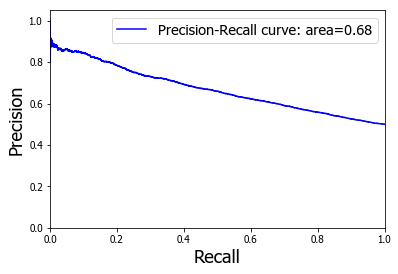

In [135]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel(r"Recall", fontsize=18)
# ax.axhline(y=0.839)
ax.set_ylabel("Precision", fontsize=18)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

precision, recall, thresholds = precision_recall_curve(test_edge_labels, test_preds)

ax.plot(recall, precision, color='b', alpha=1, label ="Precision-Recall curve: area={0:0.2f}".format(test_ap))
ax.legend(fontsize='x-large')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.savefig('ecoli_pr_curve.eps', dpi =1200)
plt.show()

In [110]:
thresholds

array([ 0.00858221,  0.00884936,  0.00900816, ...,  0.99337359,
        0.99342438,  0.99493122])

In [91]:
import scikitplot as skplt

In [101]:
skplt.metrics.plot_precision_recall_curve(test_labels, edge_classifier.predict_proba(test_data))

array([ 0.25267534,  0.12663033,  0.46553919, ...,  0.42439845,
        0.41614971,  0.68247825])

(25670, 128)

In [163]:
test_preds

array([ 0.42760831,  0.16333067,  0.63636398, ...,  0.27837765,
        0.03712028,  0.05281949])

In [162]:
test_labels

array([ 1.,  1.,  1., ...,  0.,  0.,  0.])

In [43]:
df = evaluation_data

In [44]:
df

,0,1,2
0,339,4264,1
1,649,2147,1
2,4216,1904,1
3,1237,3801,1
4,561,3809,1
5,226,4198,1
6,3441,3750,1
7,2958,2377,1
8,3689,1729,1
9,3720,613,1


In [45]:
df['predicted'] = test_preds

In [47]:
df = df.sort_values(['predicted'], ascending=False)

In [48]:
df

,0,1,2,predicted
8352,3595,3279,1,0.999925
2692,3475,3279,1,0.999893
485,3279,2405,1,0.999877
7150,2776,3494,1,0.999874
1332,4284,4102,1,0.999829
7750,3557,3279,1,0.999775
7117,4379,4026,1,0.999754
1728,4384,712,1,0.999688
1086,4057,4419,1,0.999582
5481,3339,4489,1,0.999562


In [49]:
df.to_csv("../Gene-Network-Embedding/data/ecoli/latest_predictions.txt", index=False, header=False, sep=",")

In [178]:
test_roc = roc_auc_score(df.iloc[:,2], df.iloc[:,3])
test_ap = average_precision_score(df.iloc[:,2], df.iloc[:,3])

In [92]:
print('GNE Test ROC score: ', str(test_roc))
print('GNE Test AP score: ', str(test_ap))

GNE Test ROC score:  0.5077792537597847
GNE Test AP score:  0.511080217350957
